This notebook implements facial landmark detection, lip segmentation, and lighting estimation for lipstick rendering.

In [2]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

In [3]:
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import json

## Step 1: Load CelebA Metadata

In [4]:
def load_celeba_data(image_dir = "test_publishable_list"):
    # Assuming images are stored in 'test_publishable_list' directory relative to metadata file
    image_files = []
    print("path ",image_dir + " exists ",os.path.exists(image_dir))
    if os.path.exists(image_dir):
        image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.startswith('test_publishable_list')]
    # if os.path.exists(image_dir):
    #     for f in os.listdir(image_dir):
    #         if f.startswith('test_publishable_list'):
    #             exr_path = os.path.join(image_dir, f, '1_Albedo.exr')
    #             if os.path.exists(exr_path):
    #                 image_files.append(exr_path)
    return image_files


files = load_celeba_data("test_publishable_list")

path  test_publishable_list exists  True


## Step 2: Image Processing Functions

path  test_publishable_list exists  True


I0000 00:00:1733641394.778992  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733641394.781707  281257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733641394.787567  281255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733641394.789911  281257 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


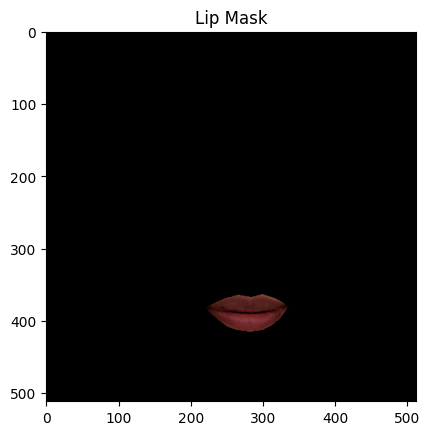

In [5]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # For HDR EXR files, clip to [0, 1] and convert to 8-bit
    if image.dtype == np.float32:  
        image = np.clip(image, 0, 1) 
        image = (image * 255).astype(np.uint8)

    image_resized = cv2.resize(image, (512, 512))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    return image_rgb

def lip_segmentation(image_rgb):
    # mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    results = face_mesh.process(image_rgb)
    
    lip_indices = [
        61, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        291, 61, 185, 40, 39, 37, 0, 267, 269, 270,
        409, 291, 78, 95, 88, 178, 87, 14, 317, 402,
        318, 324, 308, 78, 191, 80, 81, 82, 13, 312,
        311, 310, 415, 308
    ]
    
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        lip_landmarks = [face_landmarks.landmark[i] for i in lip_indices]
        mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
        points = [
            (int(landmark.x * image_rgb.shape[1]), int(landmark.y * image_rgb.shape[0]))
            for landmark in lip_landmarks
        ]
        points = np.array(points, dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
        lip_mask = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
        return lip_mask, mask
    return None, None

def display_image(image, title="Title"):
    plt.imshow(image)
    plt.title(title)
    plt.show()

files = load_celeba_data("test_publishable_list")
file0 = files[0]
pp_img = preprocess_image(os.path.join(file0, '1_Albedo.exr'))
lip_mask, mask = lip_segmentation(pp_img)
display_image(lip_mask, "Lip Mask")


## Step 3: Lighting Estimation

In [6]:
import torch

def evaluate_sh_basis_gpu(theta, phi):
    """Vectorized SH basis computation on GPU"""
    sh_basis = torch.zeros((theta.shape[0], 9), device=theta.device)
    
    # Y00
    sh_basis[:, 0] = 0.282095 * torch.ones_like(theta)
    # Y1m
    sh_basis[:, 1] = 0.488603 * torch.sin(theta) * torch.cos(phi)
    sh_basis[:, 2] = 0.488603 * torch.sin(theta) * torch.sin(phi)
    sh_basis[:, 3] = 0.488603 * torch.cos(theta)
    # Y2m
    sh_basis[:, 4] = 1.092548 * torch.sin(theta)**2 * torch.cos(2*phi)
    sh_basis[:, 5] = 1.092548 * torch.sin(theta) * torch.cos(theta) * torch.cos(phi)
    sh_basis[:, 6] = 0.315392 * (3*torch.cos(theta)**2 - 1)
    sh_basis[:, 7] = 1.092548 * torch.sin(theta) * torch.cos(theta) * torch.sin(phi)
    sh_basis[:, 8] = 0.546274 * torch.sin(theta)**2 * torch.cos(2*phi)
    
    return sh_basis

In [65]:
import torch
import numpy as np

def estimate_lighting_gpu(image_rgb, face_landmarks, device='cuda'):
    """GPU-accelerated lighting estimation using spherical harmonics"""
    # Convert inputs to torch tensors with explicit dtype
    image_tensor = torch.from_numpy(image_rgb).float().to(device)
    
    # Extract face geometry
    image_h, image_w = image_rgb.shape[:2]
    vertices = torch.tensor([
        [landmark.x * image_w, landmark.y * image_h, landmark.z]
        for landmark in face_landmarks.landmark
    ], dtype=torch.float32, device=device)
    
    # Compute face normals using neighboring vertices
    v1 = vertices[1:-1] - vertices[:-2]  # Size: N-2
    v2 = vertices[2:] - vertices[1:-1]   # Size: N-2
    
    # Debug size check
    assert v1.shape == v2.shape, f"Shape mismatch: v1 {v1.shape} vs v2 {v2.shape}"
    
    normals = torch.cross(v1, v2)
    normals = normals / (torch.norm(normals, dim=1, keepdim=True) + 1e-6)  # Add epsilon to avoid div by 0
    
    # Create face mask
    face_mask = torch.zeros((image_h, image_w), dtype=torch.float32, device=device)
    points = vertices[:, :2].cpu().numpy().astype(np.int32)
    face_mask = torch.from_numpy(
        cv2.fillConvexPoly(face_mask.cpu().numpy(), points, 1)
    ).to(device)
    
    # Sample face colors and positions
    y_coords, x_coords = torch.where(face_mask > 0)
    colors = image_tensor[y_coords, x_coords].float()  # Ensure float type
    
    # Convert to spherical coordinates
    positions = torch.stack([
        x_coords.float() / image_w * 2 - 1,
        y_coords.float() / image_h * 2 - 1
    ], dim=1)
    
    # Compute spherical harmonics basis
    theta = torch.arccos(torch.clamp(positions[:, 1], -1, 1))
    phi = torch.arctan2(positions[:, 0], torch.ones_like(positions[:, 0]))
    
    # Evaluate SH basis functions
    sh_basis = evaluate_sh_basis_gpu(theta, phi)
    
    # Debug dtype check
    assert sh_basis.dtype == colors.dtype, f"Dtype mismatch: sh_basis {sh_basis.dtype} vs colors {colors.dtype}"
    
    # Solve for coefficients using least squares
    sh_coefficients = torch.linalg.lstsq(sh_basis, colors).solution[:9]
    
    return sh_coefficients.cpu().numpy()



## Step 4: Physically-Inspired Lipstick Rendering

In [15]:
'''Helper Functions'''

def feather_mask(binary_mask, blur_radius=15):
    # Apply Gaussian blur to create a soft gradient around given mask
    feathered_mask = cv2.GaussianBlur(binary_mask, (blur_radius, blur_radius), 0)
    feathered_mask = np.clip(feathered_mask, 0, 255).astype(np.uint8)
    return feathered_mask


def blend_albedo(albedo, lip_binary_mask, lipstick_color, blend_factor=0.5):
    # Blend albedo with provided lipstick color
    lipstick_layer = np.zeros_like(albedo)
    lipstick_layer[:, :] = lipstick_color   
    masked_lipstick = cv2.bitwise_and(lipstick_layer, lipstick_layer, mask=lip_binary_mask)
    masked_albedo = cv2.bitwise_and(albedo, albedo, mask=lip_binary_mask)
    blended_albedo = cv2.addWeighted(masked_albedo, 1 - blend_factor, masked_lipstick, blend_factor, 0)
    return blended_albedo


def adjust_specular_with_roughness(specular_map, roughness_map, intensity=1.0):
    # Use roughness to adjust specular highlights
    gloss_factor = 1 - roughness_map / 255.0
    highlights = cv2.multiply(specular_map.astype(np.float64), gloss_factor)
    highlights = (highlights * intensity).astype(np.uint8)
    return highlights

def apply_fresnel_effect(specular_map, depth_map, lip_binary_mask, intensity=1.0):
    # Normalize depth map and compute Fresnel term
    normalized_depth = cv2.normalize(depth_map, None, 0, 1, cv2.NORM_MINMAX)
    fresnel_effect = 1 - np.power(normalized_depth, 2)
    enhanced_specular = (specular_map.astype(np.float32) * fresnel_effect * intensity)
    masked_specular = cv2.bitwise_and((enhanced_specular).astype(np.uint8),
                                      (enhanced_specular).astype(np.uint8),
                                      mask=lip_binary_mask)
    return masked_specular

def composite_final_image(albedo_image, albedo, diffuse, specular):
    # Combine diffuse and specular components (adjustable)
    blended_mask = cv2.addWeighted(diffuse, 0.1, specular, 0.8, 0)
    # Combine lighting components with lipstick color (adjustable)
    blended_mask = cv2.addWeighted(albedo, 1.0, blended_mask, 0.8, 0)
    # Apply combined masks in a smooth gradient manner
    feathered_mask = feather_mask(blended_mask, blur_radius=7)
    blended_mask = cv2.addWeighted(albedo_image, 1.0, feathered_mask, 1.0, 0)
    return blended_mask



## Main Processing Pipeline

In [16]:
import os

# Load CelebA Metadata
# metadata_path = 'celeba-dataset-metadata.json'
image_files = load_celeba_data("test_publishable_list") # change this on different devices

# Create output directory if it doesn't exist
output_dir = 'lip-segmentation-outputs'
os.makedirs(output_dir, exist_ok=True)

# Process Each Image
for image_path in image_files:
    # Retrieve individual image layers
    albedo_path = os.path.join(image_path, "1_Albedo.exr")
    diffuse_path = os.path.join(image_path, "1_Diffuse.exr")
    specular_path = os.path.join(image_path, "1_Specular_naivelyscaled.exr")
    depth_path = os.path.join(image_path, "1_Depth.exr")
    roughness_path = os.path.join(image_path, "1_Roughness_map.exr")   
    if not os.path.exists(albedo_path) or not os.path.exists(diffuse_path) or not os.path.exists(specular_path) or \
        not os.path.exists(depth_path) or not os.path.exists(roughness_path):
        print("Missing image path!")
        continue

    image_albedo = preprocess_image(albedo_path)
    image_diffuse = preprocess_image(diffuse_path)
    image_specular = preprocess_image(specular_path)
    image_depth = preprocess_image(depth_path)
    image_roughness = preprocess_image(roughness_path)

    lip_mask, lip_binary_mask = lip_segmentation(image_albedo)
    lip_mask_diffuse = cv2.bitwise_and(image_diffuse, image_diffuse, mask=lip_binary_mask)
    lip_mask_specular = cv2.bitwise_and(image_specular, image_specular, mask=lip_binary_mask)
    lip_mask_depth = cv2.bitwise_and(image_depth, image_depth, mask=lip_binary_mask)
    lip_mask_roughness = cv2.bitwise_and(image_roughness, image_roughness, mask=lip_binary_mask)
    
    # Apply lipstick color to albedo image and generate albedo mask
    lipstick_color = np.array([255, 0, 0])
    blended_albedo_mask = blend_albedo(image_albedo, lip_binary_mask, lipstick_color, blend_factor=0.25)

    # Enhance specular highlights using roughness map
    adjusted_specular_mask = adjust_specular_with_roughness(lip_mask_specular, lip_mask_roughness, intensity=0.3) 

    # Composite diffuse and specular masks with the base (albedo) image
    final_image = composite_final_image(image_albedo, blended_albedo_mask, lip_mask_diffuse, adjusted_specular_mask)

    # Save composited image and lip masks
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    output_path = os.path.join(output_dir, f'{base_name}')
    os.makedirs(output_path, exist_ok=True)
    cv2.imwrite(os.path.join(output_path, 'lip_mask.png'), cv2.cvtColor(lip_mask, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(output_path, 'binary_mask.png'), lip_binary_mask)
    final_image_float = final_image.astype(np.float32) / 255.0
    cv2.imwrite(os.path.join(output_path, 'final_adjusted.exr'), cv2.cvtColor(final_image_float, cv2.COLOR_RGB2BGR))

    print(f'Processed and saved outputs for {base_name}')
    

path  test_publishable_list exists  True
Processed and saved outputs for test_publishable_list_2_340


I0000 00:00:1733642614.908597  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642614.909823  295002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642614.914116  295002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642615.044997  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642615.046410  295021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642615.051075  295021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_2_527
Processed and saved outputs for test_publishable_list_3_527


I0000 00:00:1733642615.195804  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642615.196881  295027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642615.200659  295027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642615.354033  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642615.355470  295046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642615.360177  295046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_3_340
Processed and saved outputs for test_publishable_list_1_340
Missing image path!


Context leak detected, msgtracer returned -1
I0000 00:00:1733642615.497010  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642615.498144  295072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642615.502870  295069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642615.635653  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642615.637273  295076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642615.641660  295076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_0_527
Processed and saved outputs for test_publishable_list_0_340


I0000 00:00:1733642615.828230  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642615.829360  295109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642615.833877  295108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642615.967442  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642615.968643  295127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642615.972985  295127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_4_340
Processed and saved outputs for test_publishable_list_4_527


I0000 00:00:1733642616.106181  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642616.107832  295142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642616.111917  295142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642616.251612  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642616.252713  295151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642616.256663  295153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_5_527
Processed and saved outputs for test_publishable_list_5_340


I0000 00:00:1733642616.397281  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642616.398503  295166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642616.402807  295164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642616.527110  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642616.528473  295171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642616.533173  295172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_6_527
Processed and saved outputs for test_publishable_list_6_340


I0000 00:00:1733642616.685374  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642616.686890  295178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642616.691420  295178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642616.821448  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642616.822540  295186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642616.828168  295191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_0_610
Processed and saved outputs for test_publishable_list_6_594


I0000 00:00:1733642616.970520  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642616.971913  295197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642616.977631  295194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642617.128847  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642617.130027  295207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642617.134159  295209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_1_610
Processed and saved outputs for test_publishable_list_3_610
Missing image path!


I0000 00:00:1733642617.275349  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642617.276658  295221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642617.280473  295221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642617.415334  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642617.416551  295226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642617.420946  295226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_5_594
Processed and saved outputs for test_publishable_list_2_610


I0000 00:00:1733642617.576572  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642617.577793  295243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642617.582276  295243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642617.713205  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642617.714480  295270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642617.718835  295270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_6_610
Processed and saved outputs for test_publishable_list_1_594


I0000 00:00:1733642617.860224  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642617.861413  295279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642617.865429  295285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Context leak detected, msgtracer returned -1
I0000 00:00:1733642618.010556  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642618.011778  295290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642618.016045  295289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_0_594
Processed and saved outputs for test_publishable_list_5_610


I0000 00:00:1733642618.173694  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642618.175091  295304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642618.178998  295304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642618.310079  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642618.311365  295308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642618.315149  295308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_2_594
Processed and saved outputs for test_publishable_list_3_594


I0000 00:00:1733642618.466297  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642618.467486  295317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642618.471691  295322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642618.616853  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642618.618125  295328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642618.622611  295328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_4_610
Processed and saved outputs for test_publishable_list_2_122


I0000 00:00:1733642618.793131  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642618.794346  295349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642618.798856  295353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642618.935533  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642618.936723  295359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642618.940957  295358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_3_344
Processed and saved outputs for test_publishable_list_2_344


I0000 00:00:1733642619.077716  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642619.078911  295366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642619.082833  295364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733642619.217685  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642619.218984  295375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642619.223036  295375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed and saved outputs for test_publishable_list_3_122
Processed and saved outputs for test_publishable_list_1_122


I0000 00:00:1733642619.366124  280999 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
W0000 00:00:1733642619.368962  295384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642619.373255  295382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733642619.509085  280999 gl_context_nsgl.cc:104] Requested context not created, using queried context.


RuntimeError: Service "kGpuService", required by node facedetectionshortrangecpu__facedetectionshortrange__facedetection__ImageToTensorCalculator, was not provided and cannot be created: ; RET_CHECK failure (mediapipe/gpu/gl_context_nsgl.cc:116) context_Could not create an NSOpenGLContext

# Next Step - Parallelize the processing with a dataloader type multiprocessing. Perhaps using image transform